In [ ]:
cd ../

In [2]:
import pickle
import numpy as np
import argparse
import matplotlib.pyplot as plt

import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import pdist

import cxplain
from cxplain import MLPModelBuilder, ZeroMasking, CXPlain
from tensorflow.python.keras.losses import binary_crossentropy, categorical_crossentropy

from tensorflow.python.keras.layers import Dense, Input, Flatten, Add, Multiply, Lambda
from tensorflow.python.keras.layers.normalization import BatchNormalization
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras import optimizers
from tensorflow.python.keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical

import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm

from utils.explanations import calculate_robust_astute_sampled
import shap
import pickle
np.random.seed(0)

/home/zulqarnain/anaconda3/envs/old_tf/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/zulqarnain/anaconda3/envs/old_tf/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/zulqarnain/anaconda3/envs/old_tf/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/zulqarnain/anaconda3/envs/ol

In [3]:
def set_all_weights(model, all_layer_weights):
    count = 0
    for layer in model.layers:
        if type(layer) is Dense:
            count += 1
    if count == len(all_layer_weights):
        c = 0
        for layer in model.layers:
            if type(layer) is Dense:
                layer.set_weights(all_layer_weights[c])
                c += 1
        return model
    else:
        print("models don't match")

In [4]:
datatype = 'cifar10'
run_times = 3
prop_points = 1
calculate = False
epsilon_range = np.arange(0.01, 1.1, 0.05)
masking_operation = ZeroMasking()
loss = categorical_crossentropy

In [5]:
cifar = pickle.load(open('data/cifar10_10_10_train.pkl', 'rb'))
data = cifar[1]
labels = cifar[0]
x_train, x_val, y_train, y_val = train_test_split(data, labels, test_size=0.1, random_state=42)
x_train, x_val = np.array(x_train), np.array(x_val)
x_train, x_val = x_train.reshape((len(x_train), -1)), x_val.reshape((len(x_val), -1))
y_train, y_val = to_categorical(y_train), to_categorical(y_val)
input_shape = x_train.shape[-1]

In [6]:
save_astuteness_file = 'plots/cxplain_' + datatype + '_astuteness_classifiers_lip.pk'
lambda_dense_list = [float(1.5), float(2), float("inf")]
lambda_names = ['Regularized High', 'Regularized Low', 'Not Regularized']

In [7]:
if calculate:
    median_rad = np.median(pdist(x_train))
    total_astuteness = np.zeros(shape=(run_times, len(lambda_dense_list), len(epsilon_range)))
    for i in range(run_times):
        print('Completing Run ' + str(i + 1) + ' of ' + str(run_times))
        for (j, lambda_dense) in enumerate(lambda_dense_list):
                all_layer_weights = pickle.load(open('extracted_weights/cifar10_l2_' + str(j) + '.pk', 'rb'))
                activation = 'relu'

                model_input = Input(shape=(input_shape,), dtype='float32')
                net = Dense(64, activation=activation, name='dense1',
                            kernel_regularizer=regularizers.l2(1e-3))(model_input)
                net = Dense(64, activation=activation, name='dense2',
                            kernel_regularizer=regularizers.l2(1e-3))(net)
                net = Dense(64, activation=activation, name='dense3',
                            kernel_regularizer=regularizers.l2(1e-3))(net)
                net = Dense(64, activation=activation, name='dense4',
                            kernel_regularizer=regularizers.l2(1e-3))(net)
                preds = Dense(10, activation='softmax', name='dense5',
                              kernel_regularizer=regularizers.l2(1e-3))(net)
                bbox_model = Model(model_input, preds)
                bbox_model = set_all_weights(bbox_model, all_layer_weights)
                pred_model = Model(model_input, preds)
                model_builder = MLPModelBuilder(num_layers=4, num_units=64, activation=activation, verbose=0,
                                batch_size=32, learning_rate=0.001, num_epochs=100, early_stopping_patience=15,
                                with_bn=False)
                explainer = CXPlain(pred_model, model_builder, masking_operation, loss, num_models=1)
                explainer.fit(x_train, y_train)
                for k in tqdm(range(len(epsilon_range))):
                    _, total_astuteness[i, j, k], _ = calculate_robust_astute_sampled(data=x_val,
                                                                                      explainer=explainer,
                                                                                      explainer_type='cxplain',
                                                                                      explanation_type='attribution',
                                                                                      ball_r=median_rad,
                                                                                      epsilon=epsilon_range[k],
                                                                                      num_points=int(
                                                                                          prop_points * len(
                                                                                              x_val)),
                                                                                      NN=True,
                                                                                      data_explanation=None)     
    pickle.dump(total_astuteness, open(save_astuteness_file, 'wb'))
else:
    total_astuteness = pickle.load(open(save_astuteness_file, 'rb'))


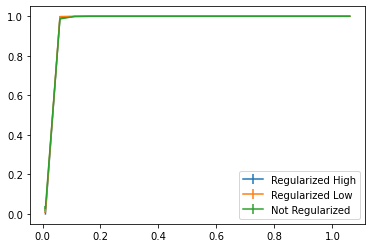

In [8]:
astuteness_mean = total_astuteness.mean(axis=0)
astuteness_std = total_astuteness.std(axis=0)
image_name = 'plots/cxplain_' + datatype + '_astuteness_classifiers.PNG'
fig, ax = plt.subplots()
for i in range(len(lambda_names)):
    ax.errorbar(x=epsilon_range, y=astuteness_mean[i, :], yerr=astuteness_std[i, :],
                label=lambda_names[i])
plt.legend()
plt.savefig(image_name)
plt.show()
plt.close()

In [9]:
x_val.shape

(5000, 300)